# Problem Statement:
He actually did it! Long time friend Ben Seller sold off his dad's old real estate company and invested it ALL into bitcoin! Lucky for him he bought at just the right time and bitcoin skyrocketed! He's a millionaire! Ben has come to me asking for help, again. He has been receiving a massive outpouring of financial advice from his friends and family, and he needs a quick way to decide what is actual financial advice and what is not.

By pulling data from the popular website Reddit, specifically the subreddits r/personalfinance and r/frugal, I will construct a model that will determine if the advice Ben is being given is “sound” financial advice, or just general advice about ways to save money. 

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
finance = pd.read_csv('./data/personal_finance.csv')

In [3]:
finance.shape

(10533, 10)

In [4]:
finance.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,link_flair_text,timestamp
0,Financing instead of out right buying a phone!...,"Hello all,\n\n&amp;#x200B;\n\nI am considering...",personalfinance,1619480104,Complete_Thought,3,1,True,Credit,2021-04-26
1,Anybody know of a place online that would loan...,[removed],personalfinance,1619480405,IcanMakeThePiecesFit,1,1,True,Other,2021-04-26
2,"Inheriting Traditional Thrift Savings Plan, mo...",Seeing conflicting information about this incl...,personalfinance,1619480406,fordry,8,1,True,Retirement,2021-04-26
3,I couldn’t spend my allocated fun money,"I’m 32f, married with no kids. \n\nI describe ...",personalfinance,1619480411,awesomeSHIT88,16,1,True,Budgeting,2021-04-26
4,Is Zengo Trades trustworthy?,Basically there’s this company that has a cryp...,personalfinance,1619480481,lil_bomby,3,1,True,Investing,2021-04-26


In [5]:
frugal = pd.read_csv('./data/frugal_total.csv')

In [6]:
frugal.shape

(10154, 11)

In [7]:
frugal.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,link_flair_text,timestamp
0,1,Budget lipo?,[removed],Frugal,1619426102,Acrobatic-Captain-97,0,1,True,NaN,2021-04-26
1,2,Heating enough water for a hot water bottle. W...,I refill my hot water bottle every few hours d...,Frugal,1619430864,chasserdieu,15,1,True,Tip/advice,2021-04-26
2,4,Safelite windshield replacement,"This may or may not be the place to post this,...",Frugal,1619439826,imtalkintou,41,1,True,NaN,2021-04-26
3,5,Investing in hens to save on eggs?,Worth it? I can make feed for next to nothing....,Frugal,1619439998,westcivilization,5,1,True,NaN,2021-04-26
4,6,Get Free 200$ Amazon gift card,[removed],Frugal,1619447665,RonSloat,0,1,True,NaN,2021-04-26


I plan to lose about half the rows of data to cleaning so both of the data frames are about the right size. Need to fix the index of the Frugal data frame. 

In [8]:
frugal.drop(columns='Unnamed: 0', inplace=True)

Create a main data frame to clean up all of the data at the same time. The main column of focus will be the text column. Thankfully both of these subreddits are pretty well moderated so the text data is already mostly very clean. 

In [9]:
main_df = pd.concat([finance,frugal])

In [10]:
main_df.shape

(20687, 10)

In [11]:
main_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Removing the removed or moderated post since they will not help with the modeling:

In [12]:
main_df.drop(main_df[main_df['selftext'] == '[removed]'].index, inplace=True)

In [13]:
main_df.drop(main_df[main_df['selftext'] == '[deleted]'].index, inplace=True)

In [14]:
main_df['selftext'].fillna('to drop', inplace=True) 

In [15]:
main_df.drop(main_df[main_df['selftext'] == 'to drop'].index, inplace=True)

In [16]:
main_df['selftext'].value_counts().head()

Welcome to the weekly thread for sharing your finds, hauls, tips and tricks. \n\nWhether actual thrift store finds, a haul from couponing, something you found and put to use, or just a life change you wanted to share, it belongs here. \n\nPlease be mindful of the rules when commenting,                                                                                                     33
Welcome to the weekly thread for sharing your finds, hauls, tips and tricks. \n\nWhether actual thrift store finds, a haul from couponing, something  you found and put to use, or just a life change you wanted to share, it  belongs here.                                                                                                                                                       11
Title                                                                                                                                                                                                                       

removing the weekly threads that show up in the pulls:

In [17]:
main_df.drop(main_df[main_df['selftext'].str.contains('Welcome to the weekly thread for sharing')].index, inplace=True)

In [18]:
main_df['selftext'].value_counts().head()

Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      3
I searched for a large cold brew coffee maker but couldn't find one larger than a gallon. I thought there must be reusable filters but they were expensive as well. I then purchased a 3 li

In [19]:
main_df.isnull().sum()

title                 0
selftext              0
subreddit             0
created_utc           0
author                0
num_comments          0
score                 0
is_self               0
link_flair_text    5282
timestamp             0
dtype: int64

In [20]:
main_df['subreddit'].value_counts()

personalfinance    6351
Frugal             6077
Name: subreddit, dtype: int64

Now that most of the cleaning is done, checking to make sure there are enough data points in each subreddit for our model. The only nulls left in the data set are in the "flair" column. I want to do some EDA on that column, and it appears the nulls are just posts that did not have flair, so I will impute the value 'no_flair'. 

In [21]:
main_df['link_flair_text'].fillna('no_flair', inplace=True)

In [22]:
main_df['link_flair_text'].value_counts()

no_flair                           5282
Retirement                          817
Taxes                               785
Other                               769
Investing                           682
Housing                             648
Credit                              556
Debt                                541
Auto                                334
Advice Needed                       311
Planning                            288
Saving                              271
Employment                          252
Insurance                           204
Budgeting                           196
Tip/advice                          131
Discussion                          108
Frugal Win                           52
Food shopping                        34
Opinion                              23
Electronics                          18
Cooking                              17
Home &amp; apt                       17
Clothing &amp; shoes                 14
Personal care                        12


In [23]:
main_df.isnull().sum()

title              0
selftext           0
subreddit          0
created_utc        0
author             0
num_comments       0
score              0
is_self            0
link_flair_text    0
timestamp          0
dtype: int64

Cleaning the text column, thankfully the column is relatively clean already, I plan to use some regex to get rid of the links that are in the post, and to get rid of all the line breaks. The regex leaves some artifacts behind that will also have to be dealt with. 

In [24]:
#get rid of links and line breaks
main_df['selftext'] = main_df['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)

In [25]:
main_df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,link_flair_text,timestamp
2,"Inheriting Traditional Thrift Savings Plan, mo...",eeing conflicting information about this inclu...,personalfinance,1619480406,fordry,8,1,True,Retirement,2021-04-26
3,I couldn’t spend my allocated fun money,"I’m 32f, married with no kids. describe mysel...",personalfinance,1619480411,awesomeSHIT88,16,1,True,Budgeting,2021-04-26
6,I got a letter from the Treasury stating I sho...,I already received the last timulus check last...,personalfinance,1619480867,Djeff_,2,1,True,Planning,2021-04-26
7,Home appraised value went up 11% (22k) from 20...,The deadline for appealing the appraisal is M...,personalfinance,1619480872,kittiemomo,21,1,True,Taxes,2021-04-26
9,Pulling my 401k for a down payment on a home,"I don't know what information to give, so I ap...",personalfinance,1619481130,temporary_duck,21,1,True,Housing,2021-04-26


In [26]:
main_df['selftext'].value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   6
&amp;#x200B;                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [27]:
main_df['selftext'].replace("[", "to_drop_2", inplace=True)

In [28]:
main_df.drop(main_df[main_df['selftext'] == 'to_drop_2'].index, inplace=True)

In [29]:
main_df.drop(main_df[main_df['selftext'] == 'Title'].index, inplace=True)

In [30]:
main_df.drop(main_df[main_df['selftext'].str.contains('&amp;#x200B;')].index, inplace=True)

In [31]:
main_df.drop(main_df[main_df['selftext'].str.contains('BFast BFree From Playtore and Earn Free BITCOIN')].index, inplace=True)

In [32]:
main_df['selftext'].value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   6
I searched for a large cold brew coffee maker but couldn't find one larger than a gallon. I thought there must be reusable filters but they were expensive as well. I then purchased a 3 liter pitcher for 2 dollars and got one of the reusable mesh produce bags and put in the amount of coffee recommended (420 grams). 24 hours later I have delicious cold brew coffee in bulk for cheap!                                                    

dealing with repost and repeated content. 

In [33]:
main_df['author'].value_counts()

spitfire9107           23
Ukrainepolandborder    20
git_world              15
stao916                14
transburneracct        12
                       ..
HogFin                  1
RealMrMars              1
lotusm00n               1
yuubnuub                1
calowiemarlee           1
Name: author, Length: 10867, dtype: int64

In [34]:
sum(main_df['selftext'].value_counts() > 1)

36

36 post are seen more than once in the corpus, removing just these 36 rows should take care of most of our cleaning. 

In [35]:
main_df.shape

(12383, 10)

In [36]:
main_df.drop_duplicates(subset= ['selftext'] , inplace=True)

In [37]:
main_df.shape

(12342, 10)

In [38]:
sum(main_df['selftext'].value_counts() > 1)

0

create a modeling data frame that we can export and use to make models in another notebook, before continuing EDA in the rest of this notebook. The modeling DF will have just the target column for the model, subreddit, and the text column. 

In [39]:
modeling_df = main_df[['selftext', 'subreddit']].copy()

In [40]:
modeling_df.isnull().sum()

selftext     0
subreddit    0
dtype: int64

In [41]:
modeling_df.reset_index(drop=True, inplace=True)

In [42]:
modeling_df['target'] = modeling_df['subreddit'].map(lambda x: 1 if x == 'personalfinance' else 0)

In [43]:
modeling_df['target'].value_counts()

1    6318
0    6024
Name: target, dtype: int64

In [44]:
modeling_df.head()

,selftext,subreddit,target
0,eeing conflicting information about this inclu...,personalfinance,1
1,"I’m 32f, married with no kids. describe mysel...",personalfinance,1
2,I already received the last timulus check last...,personalfinance,1
3,The deadline for appealing the appraisal is M...,personalfinance,1
4,"I don't know what information to give, so I ap...",personalfinance,1


In [45]:
#modeling_df.to_csv('./data/modeling_data.csv', index=False)

At his point all the models will be tested in the modeling notebook, while EDA is continued on in this notebook. This data frame was exported and used for all the models, any remaining transformations were done to look for relationships and interesting features. 

# EDA

Exploratory data analysis will be done to look if a model between these two subreddits makes sense. At the end of the section you will find the conclusions of the EDA and the suggestions to Mr. Seller about the conclusions.

In [46]:
sns.set_style('darkgrid') #makes gaphs have a nice background 

In [47]:
df = main_df.copy() #didnt want to mess with the main data frame incase I had to make sweeping changes
                    #after modeling 

This next series of code was designed to try and discover good stop words to use in the model. The general process was to vectorize the words, and then pull out a dataframe for each subreddit, graph the top words from each subreddit, compare them and add words to the list. The final list is included at the top of the section.The code for the final iteration of the process, showing the top words for each subreddit as well as the whole corpus is also included.  

In [48]:
from sklearn.feature_extraction import text 
my_stop_words = ['just', 'like','know', 've','money','don']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [49]:
cvec = CountVectorizer(stop_words=stop_words)

In [50]:
word_count = cvec.fit_transform(df['selftext'])

In [51]:
word_countdf = pd.DataFrame(word_count.todense(), columns=cvec.get_feature_names())

### Word Count for the Whole Corpus: 

In [52]:
word_countdf.shape

(12342, 28602)

In [53]:
word_countdf.sum().sort_values(ascending=False).head(15)

year       4663
pay        3901
time       3883
credit     3871
want       3576
years      3505
make       3327
account    3319
car        3153
need       3135
month      3083
new        3046
use        2755
good       2595
buy        2538
dtype: int64

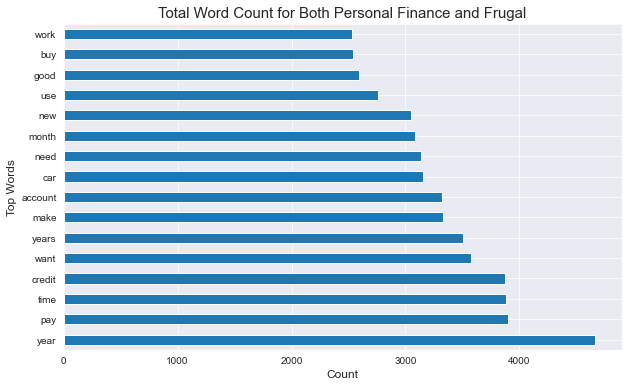

In [54]:
plt.figure(figsize=(10,6))
word_countdf.sum().sort_values(ascending=False).head(16).plot(kind='barh')
plt.title('Total Word Count for Both Personal Finance and Frugal', size = 15)
plt.xlabel('Count', size = 12)
plt.ylabel('Top Words', size = 12);

This graph shows the count of the most popular 16 words on both the subreddit r/personalfinance and r/frugal. You can see the relative money related terms that make their way into both subreddits. 

### Indivudal Word Counts for Each Subreddit: 

In [55]:
finance2 = main_df[main_df['subreddit'] == 'personalfinance']

In [56]:
finance_word_count = cvec.fit_transform(finance2['selftext'])

In [57]:
finance_word_countdf = pd.DataFrame(finance_word_count.todense(), columns=cvec.get_feature_names())

In [58]:
#storing the vectorized word counts with the original frame for later use. 
finance_info_count = pd.concat([finance_word_countdf,finance2], axis=1)

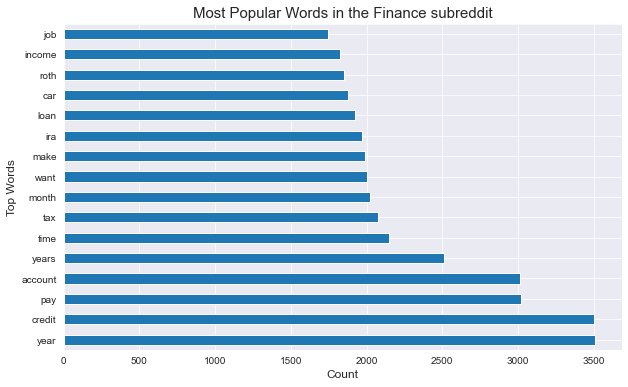

In [59]:
plt.figure(figsize=(10,6))
finance_word_countdf.sum().sort_values(ascending=False).head(16).plot(kind='barh')
plt.title('Most Popular Words in the Finance subreddit', size=15)
plt.xlabel('Count', size =12)
plt.ylabel('Top Words', size = 12);

In [60]:
frugal2 = main_df[main_df['subreddit'] == 'Frugal']

In [61]:
frugal_word_count = cvec.fit_transform(frugal2['selftext'])

In [62]:
frugal_word_countdf = pd.DataFrame(frugal_word_count.todense(), columns=cvec.get_feature_names())

In [63]:
frugal_info_count = pd.concat([frugal_word_countdf,frugal2], axis=1)

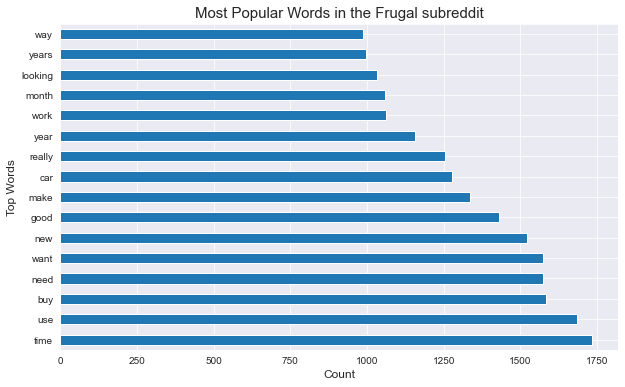

In [64]:
plt.figure(figsize=(10,6))
frugal_word_countdf.sum().sort_values(ascending=False).head(16).plot(kind='barh')
plt.title('Most Popular Words in the Frugal subreddit', size=15)
plt.xlabel('Count', size =12)
plt.ylabel('Top Words', size = 12);

Comparing these two charts you can see a clear difference between the language of the two subreddits, with some crossover. The personal finance subreddit has much more "investment" heavy terms such as Roth, account and tax. While the frugal subreddit leans more on managing money and time, and things you need vs things you want. 

### Looking at the Flair Tag and the Relative Word Counts for those Categories.

The flair is a category type for each post, in this section I will investigate the flair, mainly how many of each flair show up in each subreddit, as well as the average word count for each type of flair. This could indicate topics that the subreddit takes more seriously as longer posts generally mean more well thought out posts. 

In [65]:
main_df.groupby('subreddit')['link_flair_text'].value_counts()

subreddit        link_flair_text                
Frugal           no_flair                           5209
                 Advice Needed                       308
                 Tip/advice                          129
                 Discussion                          105
                 Frugal Win                           51
                 Food shopping                        34
                 Opinion                              23
                 Auto                                 18
                 Electronics                          18
                 Cooking                              17
                 Home &amp; apt                       17
                 Clothing &amp; shoes                 14
                 Budget                               12
                 Personal care                        12
                 Appliances                            9
                 DIY                                   9
                 Recycling &amp; zero-w

A small amount of extra cleaning on the flair column:

In [66]:
main_df['link_flair_text'] = main_df['link_flair_text'].map(lambda x: x.replace('&amp;', 'and'))  

In [67]:
main_df.groupby('subreddit')['link_flair_text'].value_counts()

subreddit        link_flair_text                
Frugal           no_flair                           5209
                 Advice Needed                       308
                 Tip/advice                          129
                 Discussion                          105
                 Frugal Win                           51
                 Food shopping                        34
                 Opinion                              23
                 Auto                                 18
                 Electronics                          18
                 Cooking                              17
                 Home and apt                         17
                 Clothing and shoes                   14
                 Budget                               12
                 Personal care                        12
                 Appliances                            9
                 DIY                                   9
                 Recycling and zero-was

Creating a word count column on the data frame to use for this section of EDA.

In [68]:
main_df['word_count'] = [len(x.split()) for x in main_df['selftext']]

Looking at the total average word count by flair for the entire corpus. Note that some of the flair types are shared between the subreddits, so this won't have far reaching insight but it will show the most generally popular categories. 

In [69]:
words_by_flair = main_df.groupby('link_flair_text')['word_count'].mean()

In [70]:
words_by_flair = pd.DataFrame(words_by_flair)

In [71]:
words_by_flair = words_by_flair['word_count'].sort_values(ascending=False)

In [72]:
words_by_flair = pd.DataFrame(words_by_flair)

In [73]:
words_by_flair.drop(labels=['Removed: Rule 3', 'R10: Missing'], axis=0, inplace=True)

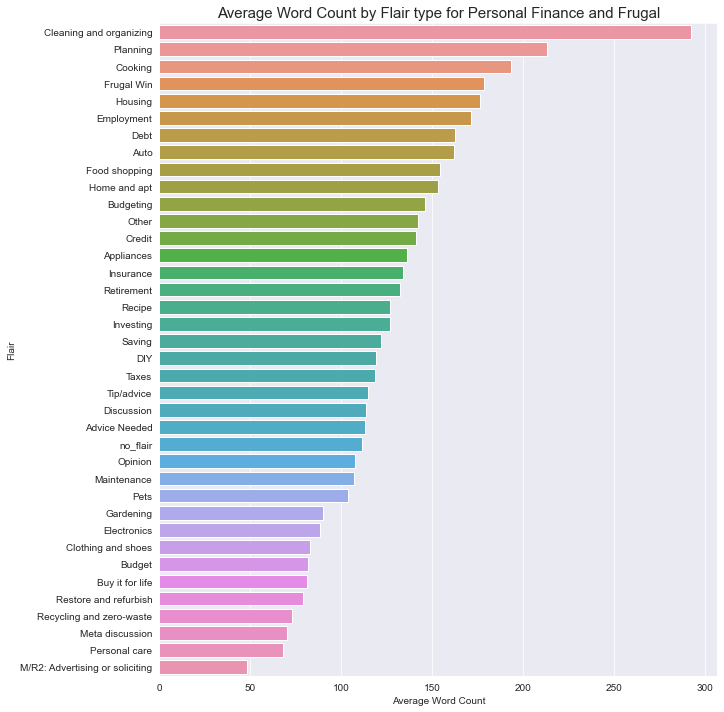

In [74]:
plt.figure(figsize=(10,12))
sns.barplot(data=words_by_flair,
           y= words_by_flair.index,
           x= 'word_count',
           orient= 'h',
           )
plt.title('Average Word Count by Flair type for Personal Finance and Frugal', size = 15)
plt.xlabel('Average Word Count')
plt.ylabel('Flair');

You can see in this graph the average word count by flair for the whole corpus. This shows the major categories that are often discussed by people when they are talking about ways to handle money, and how best to spend it. 

### Now to Look at Each Subreddit Indivdually

In [75]:
words_by_flair_subs = pd.DataFrame(main_df.groupby(['link_flair_text','subreddit'])['word_count'].mean())

In [76]:
words_by_flair_subs.reset_index(inplace=True)

In [77]:
words_by_flair_subs

,link_flair_text,subreddit,word_count
0,Advice Needed,Frugal,113.366883
1,Appliances,Frugal,136.444444
2,Auto,Frugal,144.222222
3,Auto,personalfinance,163.158730
4,Budget,Frugal,81.916667
5,Budgeting,personalfinance,145.933673
6,Buy it for life,Frugal,81.333333
7,Cleaning and organizing,Frugal,292.333333
8,Clothing and shoes,Frugal,83.000000
9,Cooking,Frugal,193.588235


Creating individual data frames for each subreddit, to make graphing them easier. The process is the same for each subreddit. 

In [78]:
finance_flair_words = words_by_flair_subs[words_by_flair_subs['subreddit'] == 'personalfinance']

In [79]:
finance_flair_words.set_index(finance_flair_words['link_flair_text'], inplace=True)

In [80]:
finance_flair_words = pd.DataFrame(finance_flair_words['word_count'].sort_values(ascending=False))

In [81]:
finance_flair_words.head()

,word_count
link_flair_text,
Planning,213.097561
Housing,176.532710
Employment,171.709163
Auto,163.158730
Debt,162.881262


In [82]:
frugal_flair_words = words_by_flair_subs[words_by_flair_subs['subreddit'] != 'personalfinance']

In [83]:
frugal_flair_words.set_index(frugal_flair_words['link_flair_text'], inplace=True)

In [84]:
frugal_flair_words = pd.DataFrame(frugal_flair_words['word_count'].sort_values(ascending=False))

In [85]:
frugal_flair_words.drop(labels=['Removed: Rule 3'], axis=0, inplace=True)

In [86]:
finance_flair_words.drop(labels=['R10: Missing'], axis=0, inplace=True)

In [87]:
frugal_flair_words.head()

,word_count
link_flair_text,
Cleaning and organizing,292.333333
Cooking,193.588235
Frugal Win,178.784314
Food shopping,154.647059
Home and apt,153.294118


graphs from those data frames! These are also included in the presentation slides. 

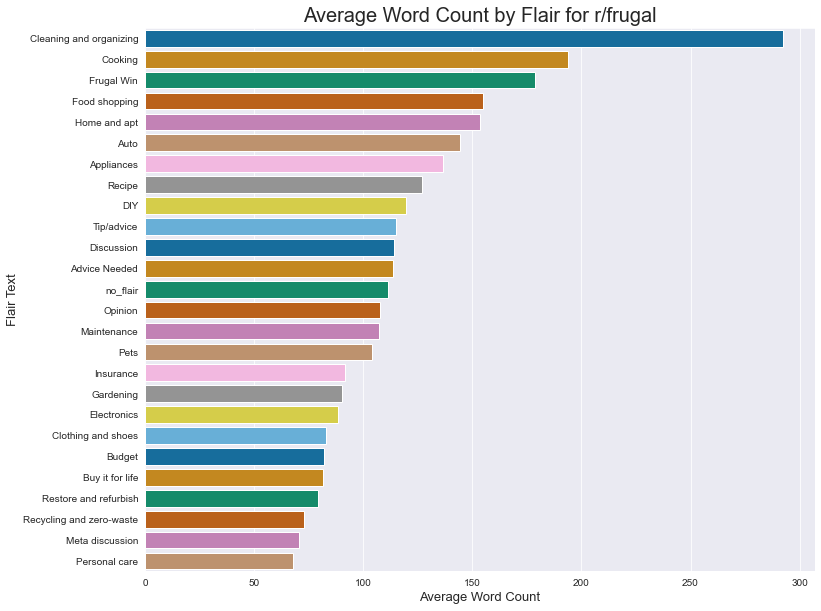

In [88]:
plt.figure(figsize=(12,10))
sns.barplot(data=frugal_flair_words,
           y= frugal_flair_words.index,
           x= 'word_count',
           orient= 'h',
           palette='colorblind')
plt.title('Average Word Count by Flair for r/frugal', size=20)
plt.xlabel('Average Word Count', size = 13)
plt.ylabel('Flair Text', size=13);

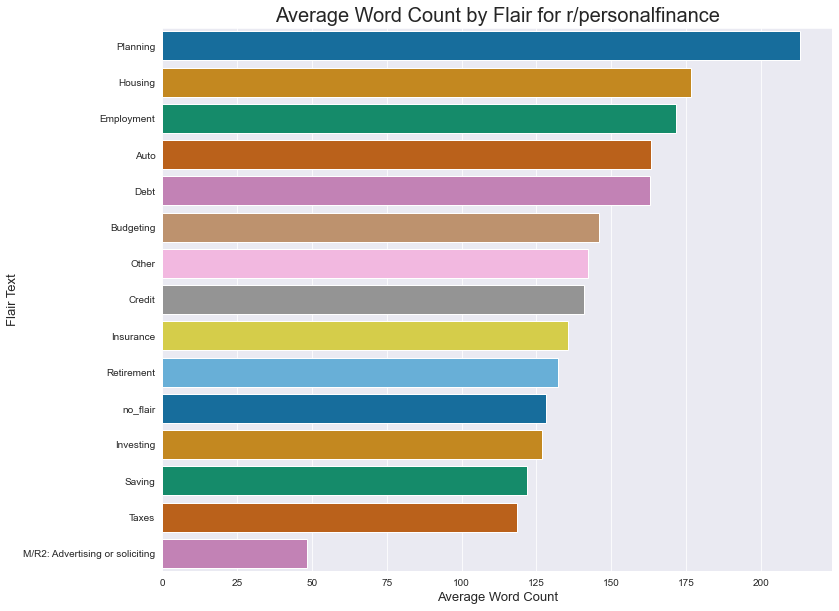

In [89]:
plt.figure(figsize=(12,10))
sns.barplot(data=finance_flair_words,
           y= finance_flair_words.index,
           x= 'word_count',
           orient= 'h',
           palette='colorblind')
plt.title('Average Word Count by Flair for r/personalfinance', size=20)
plt.xlabel('Average Word Count', size = 13)
plt.ylabel('Flair Text', size=13);

Both of these graphs show the average word count by flair for each subreddit. You can see a clear difference in the types of posts that get the most thorough post on each subreddit. Frugal is focused on cleaning, organizing, do-it-yourself, and smart shopping. Personal finance focuses more on housing, employment, debt management, and budget. These two subreddits should be different enough to build a good model that can differentiate between them. 

### Top Words and Word Ratios

This final section of EDA is done to look at the most popular words for each subreddit. The top one thousand most popular words are pulled out of each subreddit and compared to each other. After looking at top words the ratio of top words is compared. This is done by dividing the top words in personal finance by the top words frugal, thus determining how likely a word is to be in personal finance. 

In [90]:
finace_top_1000 = pd.DataFrame(finance_word_countdf.sum().sort_values(ascending=False).head(1000), columns=['finance_word_count'])

In [91]:
frugal_top_1000 = pd.DataFrame(frugal_word_countdf.sum().sort_values(ascending=False).head(1000),columns=['frugal_word_count'] )

In [92]:
top_words = pd.concat([frugal_top_1000, finace_top_1000],axis=1)

In [93]:
#values that are in one subreddit and not in the other, being filled in with zeros. 
top_words.fillna(0, inplace=True)

In [94]:
top_words['ratio'] = (top_words['finance_word_count'])/(top_words['frugal_word_count'])

In [95]:
top_words.head()

,frugal_word_count,finance_word_count,ratio
time,1732.0,2151.0,1.241917
use,1685.0,1070.0,0.635015
buy,1584.0,954.0,0.602273
need,1573.0,1562.0,0.993007
want,1573.0,2003.0,1.273363


In [96]:
top_words['ratio'].value_counts()

0.000000    383
inf         383
1.333333      3
1.375000      2
2.400000      2
           ... 
1.867403      1
1.344086      1
2.616279      1
2.013158      1
1.642857      1
Name: ratio, Length: 611, dtype: int64

After dividing to get the ratio, words that have a zero ratio are words that show up in frugals top 1000 words, and do not show up in finance. Words with a value of infinite(divide by zero) are words that show up in personal finance top 1000 words and not in frugals. I pulled those words out into their own list to look at them.

In [97]:
unique_frugal = top_words[top_words['ratio']==0]

In [98]:
unique_finance = top_words[top_words['ratio']==np.inf]

In [99]:
unique_frugal[1:6]

,frugal_word_count,finance_word_count,ratio
water,616.0,0.0,0.0
items,466.0,0.0,0.0
quality,347.0,0.0,0.0
clothes,331.0,0.0,0.0
eat,315.0,0.0,0.0


In [100]:
unique_finance.head(5)

,frugal_word_count,finance_word_count,ratio
ira,0.0,1969.0,inf
roth,0.0,1850.0,inf
401k,0.0,1441.0,inf
retirement,0.0,889.0,inf
funds,0.0,799.0,inf


Creating two new data frames to graph the top words for how likely they are to show up in personal finance and the words least likely to show up in personal finance. Remember these lists are created by the top 1000 words only, which can have an effect on the ratio, making it seem higher than it is for the whole corpus. 

In [101]:
good_ratios = top_words[(top_words['ratio']!=np.inf)& (top_words['ratio']>0)]

In [102]:
low_ratios = pd.DataFrame(good_ratios['ratio'].sort_values().head(10))

In [103]:
low_ratios

,ratio
cheap,0.114673
store,0.136066
cheaper,0.190275
amazon,0.201878
gt,0.206485
food,0.245025
expensive,0.259965
tips,0.286976
ideas,0.306502
cut,0.315625


In [104]:
high_ratios = pd.DataFrame(good_ratios['ratio'].sort_values().tail(10))

In [105]:
high_ratios

,ratio
invest,8.645570
2020,8.679245
credit,9.547684
account,9.741100
payments,11.142857
mortgage,12.377778
fund,14.701493
taxes,15.060606
loan,16.427350
tax,16.894309


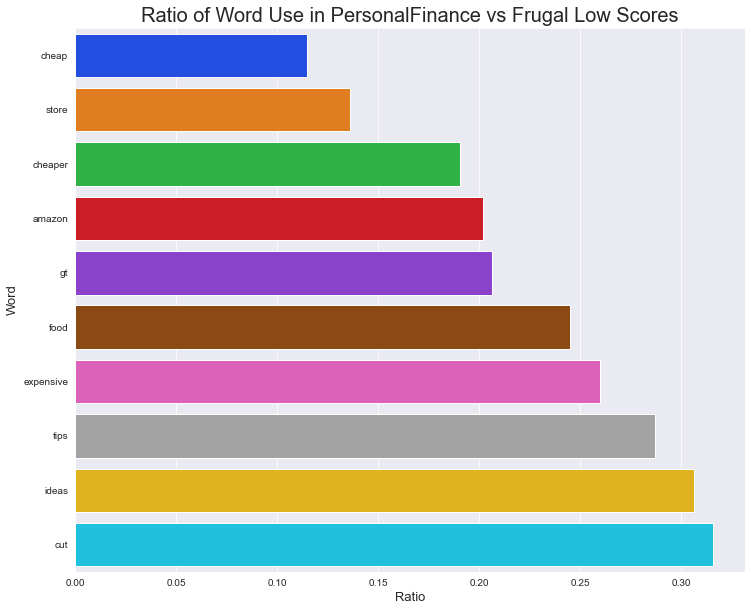

In [106]:
plt.figure(figsize=(12,10))
sns.barplot(data=low_ratios,
           y= low_ratios.index,
           x= 'ratio',
           orient= 'h',
           palette='bright')
plt.title('Ratio of Word Use in PersonalFinance vs Frugal Low Scores', size=20)
plt.xlabel('Ratio', size = 13)
plt.ylabel('Word', size=13);

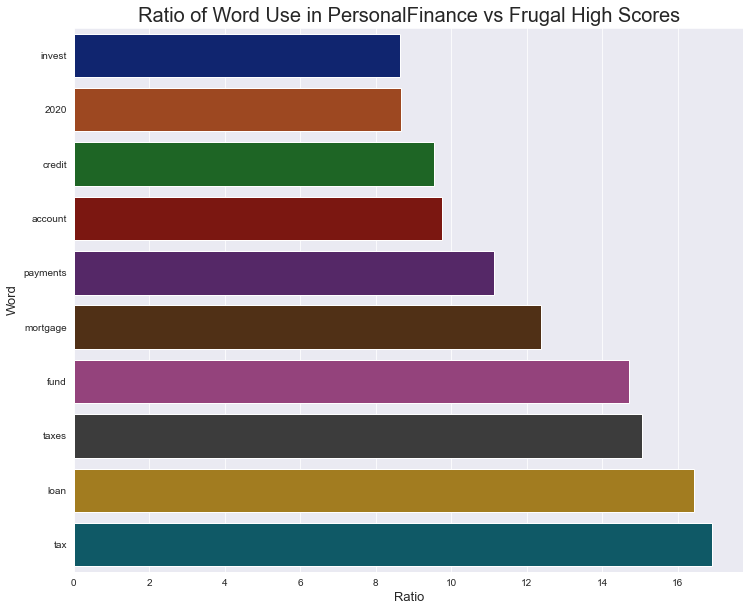

In [107]:
plt.figure(figsize=(12,10))
sns.barplot(data=high_ratios,
           y= high_ratios.index,
           x= 'ratio',
           orient= 'h',
           palette='dark')
plt.title('Ratio of Word Use in PersonalFinance vs Frugal High Scores', size=20)
plt.xlabel('Ratio', size = 13)
plt.ylabel('Word', size=13);

Both of these look at the ratio of words that are most likely to be seen in the personal finance subreddit, which is the target subreddit. There is a clear difference in the type of words that are used between the subreddits, with words like tax, loan, fund, and mortgage being much more likely to be seen in the personal finance subreddit. 

## Conclusions for EDA:

After gathering and looking at the data of text post for both of these subreddits I can conclude that there is a clear difference between the subreddits. I evaluate that a Classification model should be able to work to Mr. Seller's advantage and should provide reasonable results. The key words for personal finance will also be passed along to Mr. Seller so he can be aware of what types of words and topics are more likely to be personal finance related. 